# Auto Generated Agent Chat: Task Solving with Provided Tools as Functions

AutoGen offers conversable agents powered by LLM, tool or human, which can be used to perform tasks collectively via automated chat. This framwork allows tool use and human participance through multi-agent conversation. Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to make function calls with the new feature of OpenAI models (in model version 0613). A specified prompt and function configs need to be passed to `AssistantAgent` to initialize the agent. The corresponding functions need to be passed to `UserProxyAgent`, which will be responsible for executing any function calls made by `AssistantAgent`. Besides this requirement of matching descriptions with functions, we recommend checking the system message in the `AssistantAgent` to make sure the instructions align with the function call descriptions.

In [1]:
import os
from dotenv import load_dotenv
import langchain
import autogen

In [2]:
import pandas as pd

In [3]:
config_list = autogen.config_list_from_models(model_list=["gpt-4", "gpt-4-0613", "gpt-3.5-turbo-0613", "gpt-3.5-turbo-16k-0613"])

In [4]:
csv_file_path = "reddit_legal_cluster_test_results.csv"
df = pd.read_csv(csv_file_path)
print(f"df shape: {df.shape}")
df.head(2)

df shape: (5000, 16)


,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp
0,1078,1575952538,https://www.reddit.com/r/legaladvice/comments/...,e8lsen,I applied for a job and after two interviews I...,"Failed a drug test due to amphetamines, I have...",employment,5,[ 9.47563804e-05 5.11166630e-04 1.05712905e-...,493,"""Validity of Schedule II Drug Prescription in ...",PR,8,Employment Legal Concerns and Issues,2019-12-10 04:35:38,2019-12-10
1,2098,1577442453,https://www.reddit.com/r/legaladvice/comments/...,eg9ll2,"Hi everyone, thanks in advance for any guidanc...","Speeding ticket in Tennessee, Georgia Driver's...",driving,4,[-0.00670641 0.02091102 0.00407731 ... -0.00...,252,"""Speeding ticket consequences for out-of-state...",KY,10,Legal Topics in Traffic Violations,2019-12-27 10:27:33,2019-12-27


In [5]:
import sqlite3
from sqlalchemy import create_engine
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.utilities import SQLDatabase
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain_experimental.sql import SQLDatabaseChain
from langchain.agents.agent_types import AgentType
from langchain.tools.file_management.read import ReadFileTool
from IPython.display import Markdown

In [6]:
table_name = "reddit_legal_questions_table"
uri = "sqlite:///reddit_legal_questions_table.db"

In [7]:
def clean_names(df):
    df.columns = [x.replace(' ', '_').lower() for x in df.columns]
    return df

In [8]:
# Create the sqlalchemy engine
engine = create_engine(uri, echo=False)
# Prep column names
data = clean_names(df)
# Convert the DataFrame to SQL
data.to_sql(table_name, con=engine, index=False, if_exists='replace')

5000

In [9]:
db = SQLDatabase.from_uri("sqlite:///reddit_legal_questions_table.db")

llm = ChatOpenAI(model="gpt-3.5-turbo-16k", temperature=0, verbose=False)
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

In [10]:
res = db_chain.run("Describe the reddit_legal_questions_table table")
Markdown(f"{res}")



> Entering new SQLDatabaseChain chain...
Describe the reddit_legal_questions_table table
SQLQuery:SELECT "index", created_utc, full_link, id, body, title, text_label, flair_label, embeddings, token_count, llm_title, state, kmeans_label, topic_title, timestamp, datestamp FROM reddit_legal_questions_table LIMIT 5
SQLResult: [(1078, 1575952538, 'https://www.reddit.com/r/legaladvice/comments/e8lsen/failed_a_drug_test_due_to_amphetamines_i_have_a/', 'e8lsen', 'I applied for a job and after two interviews I was given for and agreed to an offer letter, had a start date.  The only remaining variable was a drug test, which I prepared myself for by bringing all my prescriptions with me.  \n\nI take Adderall, my doctor prescribes me for 3 pills a day,...', 'Failed a drug test due to amphetamines, I have a prescription. How long are prescriptions valid after you get them filled?', 'employment', 5, '[ 9.47563804e-05  5.11166630e-04  1.05712905e-02 ... -1.08231462e-02\n -2.02677153e-02 -2.95068244

Question: Describe the reddit_legal_questions_table table
SQLQuery: SELECT "index", created_utc, full_link, id, body, title, text_label, flair_label, embeddings, token_count, llm_title, state, kmeans_label, topic_title, timestamp, datestamp FROM reddit_legal_questions_table LIMIT 5

In [11]:
toolkit = SQLDatabaseToolkit(db=db, llm=OpenAI(temperature=0))

In [12]:
agent_executor = create_sql_agent(
    llm=ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613"),
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS
)

In [13]:
agent_executor.run("Describe the reddit_legal_questions_table table")



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


reddit_legal_questions_table
Invoking: `sql_db_schema` with `reddit_legal_questions_table`



CREATE TABLE reddit_legal_questions_table (
	"index" BIGINT, 
	created_utc BIGINT, 
	full_link TEXT, 
	id TEXT, 
	body TEXT, 
	title TEXT, 
	text_label TEXT, 
	flair_label BIGINT, 
	embeddings TEXT, 
	token_count BIGINT, 
	llm_title TEXT, 
	state TEXT, 
	kmeans_label BIGINT, 
	topic_title TEXT, 
	timestamp TEXT, 
	datestamp TEXT
)

/*
3 rows from reddit_legal_questions_table table:
index	created_utc	full_link	id	body	title	text_label	flair_label	embeddings	token_count	llm_title	state	kmeans_label	topic_title	timestamp	datestamp
1078	1575952538	https://www.reddit.com/r/legaladvice/comments/e8lsen/failed_a_drug_test_due_to_amphetamines_i_have_a	e8lsen	I applied for a job and after two interviews I was given for and agreed to an offer letter, had a st	Failed a drug test due to amphetamines, I have a prescription. 

"The `reddit_legal_questions_table` table has the following columns:\n\n- index (BIGINT)\n- created_utc (BIGINT)\n- full_link (TEXT)\n- id (TEXT)\n- body (TEXT)\n- title (TEXT)\n- text_label (TEXT)\n- flair_label (BIGINT)\n- embeddings (TEXT)\n- token_count (BIGINT)\n- llm_title (TEXT)\n- state (TEXT)\n- kmeans_label (BIGINT)\n- topic_title (TEXT)\n- timestamp (TEXT)\n- datestamp (TEXT)\n\nHere are a few sample rows from the `reddit_legal_questions_table` table:\n\n1. index: 1078, created_utc: 1575952538, full_link: [link], id: e8lsen, body: [body], title: [title], text_label: Failed a drug test due to amphetamines, I have a prescription. How long are prescriptions valid after employment?, flair_label: 5, embeddings: [embeddings], token_count: 493, llm_title: Validity of Schedule II Drug Prescription in Texas: When does it expire?, state: PR, kmeans_label: 8, topic_title: Employment Legal Concerns and Issues, timestamp: 2019-12-10 04:35:38, datestamp: 2019-12-10\n\n2. index: 2098, crea

In [14]:
# Define a function to generate llm_config from a LangChain tool
def generate_llm_config(tool):
    # Define the function schema based on the tool's args_schema
    function_schema = {
        "name": tool.name.lower().replace (' ', '_'),
        "description": tool.description,
        "parameters": {
            "type": "object",
            "properties": {},
            "required": [],
            "role": "assistant"
        },
    }

    if tool.args is not None:
      function_schema["parameters"]["properties"] = tool.args

    return function_schema

In [15]:
tools = []
function_map = {}

for tool in toolkit.get_tools():
    tool_schema = generate_llm_config(tool)
    print(tool_schema)
    tools.append(tool_schema)
    function_map[tool.name] = tool._run
    
print(function_map)

{'name': 'sql_db_query', 'description': "Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', using sql_db_schema to query the correct table fields.", 'parameters': {'type': 'object', 'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': [], 'role': 'assistant'}}
{'name': 'sql_db_schema', 'description': "Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: 'table1, table2, table3'", 'parameters': {'type': 'object', 'properties': {'table_names': {'title': 'Table Names', 'type': 'string'}}, 'required': [], 'role': 'assistant'}}
{'name': 'sql_db_list_tables', 'description': '

In [16]:
tools = tools[:3]

In [17]:
# Construct the llm_config
llm_config = {
  #Generate functions config for the Tool
  "functions": tools,
  "config_list": config_list, 
  "request_timeout": 360,
}

In [18]:
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={"work_dir": "coding"},
)

# Register the tool and start the conversation
user_proxy.register_function(
    function_map = function_map
)

chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
)

In [19]:
user_proxy.initiate_chat(
    chatbot,
    message="Describe the reddit_legal_questions_table table",
    llm_config=llm_config,
)

user_proxy (to chatbot):

Describe the reddit_legal_questions_table table

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: sql_db_schema *****
Arguments: 
{
"table_names": "reddit_legal_questions_table"
}
**************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION sql_db_schema...
user_proxy (to chatbot):

***** Response from calling function "sql_db_schema" *****

CREATE TABLE reddit_legal_questions_table (
	"index" BIGINT, 
	created_utc BIGINT, 
	full_link TEXT, 
	id TEXT, 
	body TEXT, 
	title TEXT, 
	text_label TEXT, 
	flair_label BIGINT, 
	embeddings TEXT, 
	token_count BIGINT, 
	llm_title TEXT, 
	state TEXT, 
	kmeans_label BIGINT, 
	topic_title TEXT, 
	timestamp TEXT, 
	datestamp TEXT
)

/*
3 rows from reddit_legal_questions_table table:
index	created_utc	full_link	id	body	title	text_label	fl

In [37]:
user_proxy = autogen.UserProxyAgent(
   name="User_proxy",
   system_message="A human admin.",
   code_execution_config={"last_n_messages": 3, "work_dir": "groupchat"},
   human_input_mode="NEVER",
)


coder = autogen.AssistantAgent(
    name="Coder",  # the default assistant agent is capable of solving problems with code
    llm_config=llm_config,
)


critic = autogen.AssistantAgent(
    name="Critic",
    system_message="""Critic. You are a helpful assistant highly skilled in evaluating the quality of a given visualization code by providing a score from 1 (bad) - 10 (good) while providing clear rationale. YOU MUST CONSIDER VISUALIZATION BEST PRACTICES for each evaluation. Specifically, you can carefully evaluate the code across the following dimensions
- bugs (bugs):  are there bugs, logic errors, syntax error or typos? Are there any reasons why the code may fail to compile? How should it be fixed? If ANY bug exists, the bug score MUST be less than 5.
- Data transformation (transformation): Is the data transformed appropriately for the visualization type? E.g., is the dataset appropriated filtered, aggregated, or grouped  if needed? If a date field is used, is the date field first converted to a date object etc?
- Goal compliance (compliance): how well the code meets the specified visualization goals?
- Visualization type (type): CONSIDERING BEST PRACTICES, is the visualization type appropriate for the data and intent? Is there a visualization type that would be more effective in conveying insights? If a different visualization type is more appropriate, the score MUST BE LESS THAN 5.
- Data encoding (encoding): Is the data encoded appropriately for the visualization type?
- aesthetics (aesthetics): Are the aesthetics of the visualization appropriate for the visualization type and the data?

YOU MUST PROVIDE A SCORE for each of the above dimensions.
{bugs: 0, transformation: 0, compliance: 0, type: 0, encoding: 0, aesthetics: 0}
Do not suggest code. 
Finally, based on the critique above, suggest a concrete list of actions that the coder should take to improve the code.
""",
    llm_config=llm_config,
)

groupchat = autogen.GroupChat(agents=[user_proxy, coder, critic], messages=[], max_round=25)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

In [39]:
groupchat.reset()
manager.reset()

In [33]:
user_proxy.initiate_chat(manager, 
                         message="download data from https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv and plot a visualization that tells us about the relationship between weight and horsepower. Save the plot to a file. Print the fields in a dataset before visualizing it.")

User_proxy (to chat_manager):

download data from https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv and plot a visualization that tells us about the relationship between weight and horsepower. Save the plot to a file. Print the fields in a dataset before visualizing it.

--------------------------------------------------------------------------------
Coder (to chat_manager):

Ok, let's solve this step by step:

1. Download the data from the URL
2. Print the fields in the dataset
3. Plot a visualization showing the relationship between 'weight' and 'horsepower' fields
4. Save the plot

Let's start step 1 and 2 by downloading the data from the URL and inspecting the column names. We are going to use pandas as it provides functionality to download CSV files over http and check its contents.

Here is the python code for this step:

```python
# filename: download_and_inspect.py

import pandas as pd

# download the CSV data
data = pd.read_csv('https://raw.githubusercontent.

User_proxy (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
Fields in the dataset:  ['Name', 'Type', 'AWD', 'RWD', 'Retail Price', 'Dealer Cost', 'Engine Size (l)', 'Cyl', 'Horsepower(HP)', 'City Miles Per Gallon', 'Highway Miles Per Gallon', 'Weight', 'Wheel Base', 'Len', 'Width']


--------------------------------------------------------------------------------
Coder (to chat_manager):

Thank you for executing the code. We can now confirm that the 'Weight' and 'Horsepower(HP)' fields are present in our dataset.

Now we'll proceed with Step 3 and 4: creating a scatter plot to visualize the relationship between 'Weight' and 'Horsepower(HP)', and saving the plot to a file. 

For this, we're going to use matplotlib library in python which provides rich functionalities for creating different types of visualizations.

Here is the python code to solve these steps:

```python
# filename: plot_visualization.py

import pandas as pd
import matplotlib.pyplot as plt

# download

User_proxy (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
Plot saved successfully as weight_vs_horsepower.png


--------------------------------------------------------------------------------
Critic (to chat_manager):

Bugs: 10/10
The code ran successfully with no bugs or syntax errors.

Data Transformation: 10/10
The data from the CSV file were appropriately utilized. There were no complex transformations required in this case, and the relevant fields of 'Weight' and 'Horsepower' were adequately extracted.

Goal Compliance: 10/10
The code perfectly achieved the intended goal of creating a scatter plot to visualize the relationship between 'Weight' and 'Horsepower'. Moreover, the plot was successfully saved to a file, as required.

Visualization Type: 10/10
A scatter plot is quite suitable for this kind of task as it effectively visualizes the relation between two numerical variables. The code adheres to this best practice.

Data Encoding: 10/10
The data encoding 

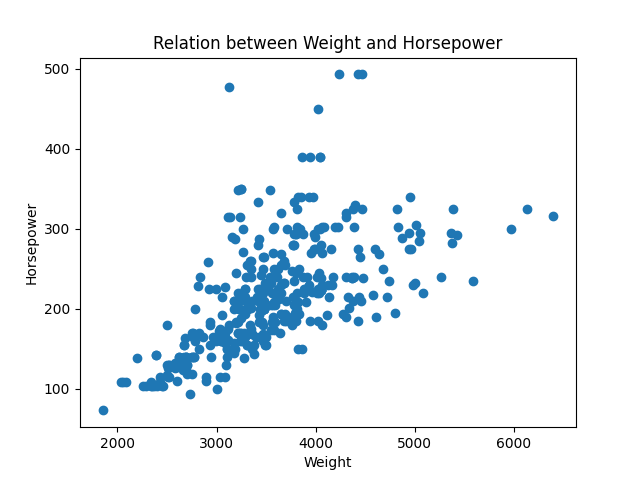

In [34]:
from IPython.display import Image

Image(filename='groupchat/weight_vs_horsepower.png')